In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/data2.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
0,30.620693,8.489570,8.919924,28.791105,20.969475,44.452351,25.952724,7.411161,10.986269,2.123410,-12.381334,-45.701370,-74.210350,-123.780014,-141.284546,-142.455505,-143.099854,-155.321487,-118.006905,-111.656380,-90.037109,-76.442963,-68.395126,-78.351456,-95.549843,-71.501266,-55.366325,-43.097916,-58.586800,-33.467007,-36.561817,-41.053299,-35.735054,-15.897057,-28.786476,-3.729527,4.192391,0.553487,-8.471565,-12.834412,12.271719,19.646893,25.044361,25.199051,31.276691,20.544123,22.255671,31.879051,39.535160,33.708031,30.974104,33.893143,53.427406,33.869221,45.211609,30.283508,55.286224,42.724392,27.231537,42.899586,41.024792,41.736843,50.331596,46.220718,21.596684,5.559279,42.829659,18.397217,52.107391,64.040771,28.830364,30.338951,21.028336,22.142103,47.700649,19.696844,39.530602,18.034081,15.962999,21.672909
1,50.741875,34.421692,27.816702,32.478642,50.412735,44.242935,44.010284,14.950229,18.534828,7.286938,-5.000367,-42.016422,-73.431747,-116.529945,-129.786102,-118.966698,-131.957779,-124.515579,-126.854858,-127.397675,-104.193604,-98.873314,-90.110367,-75.908310,-61.759636,-57.299431,-39.116890,-31.087172,-30.293434,-25.988075,-35.569450,-22.481796,-10.056782,5.815285,-11.442451,-7.637496,-9.222148,-12.171337,-9.053500,3.008300,-6.849982,-1.064360,-11.587011,6.108080,-0.355937,10.873986,6.671954,-3.511507,-3.095023,26.403328,32.569500,22.186966,23.557507,37.940533,46.750595,28.358044,18.188519,32.838013,57.035332,61.852341,57.641125,62.677948,40.041885,21.370245,18.688709,42.256836,39.700481,57.636932,31.732454,27.095018,35.294632,30.893646,19.625103,20.322369,41.542393,12.333709,26.542353,7.277061,9.382058,19.535568
2,13.836513,-19.813944,-8.628237,4.628387,26.597948,47.987488,63.669167,37.691593,55.880783,40.855171,29.742031,-12.410240,-53.916473,-131.914886,-169.124786,-177.409576,-192.273682,-160.601700,-152.165756,-116.745003,-133.557404,-114.194252,-110.823799,-94.192596,-62.182682,-51.445618,-64.093582,-46.814735,-61.833641,-26.937408,-52.058830,-49.405128,-40.886658,-41.622234,-28.846926,-14.316288,-23.997362,-7.418489,15.812813,15.047912,6.499564,-3.460285,-0.152118,-14.030814,7.926301,30.249752,35.657089,15.848862,20.581232,21.301910,39.246140,37.334435,38.704376,38.514278,31.713186,39.549278,28.753233,3.308823,42.757305,5.218519,26.496426,28.668369,73.437218,40.419460,48.220291,48.198231,11.816628,16.192842,8.361362,24.529467,38.272934,19.185558,44.249966,41.668365,52.084351,45.763813,26.096348,27.443110,26.619492,15.697024
3,71.877274,10.155208,8.221632,0.542490,6.198983,28.895584,46.328434,43.108395,28.586849,30.620750,-8.573102,-12.410401,-84.801765,-113.435699,-157.397430,-149.202545,-147.322021,-151.706360,-136.502457,-126.870056,-135.343674,-157.656464,-131.476501,-106.183334,-85.092384,-56.024982,-69.506004,-70.617142,-73.885124,-24.969410,-21.516304,-17.715244,-21.105049,-17.520195,-12.742070,-23.355083,2.928288,6.261288,5.856356,-14.677363,-11.944456,-5.453218,6.227815,2.037981,14.928480,33.301994,13.633327,41.042763,14.067127,51.932346,13.074319,15.667345,36.327896,32.295216,36.072723,64.055237,39.238995,34.168987,44.832581,46.085564,27.648678,27.383404,13.494698,9.507886,-7.903234,28.337454,10.091699,39.022522,46.910088,33.771511,20.349487,21.108273,52.432610,41.789242,33.394783,39.111580,28.485077,31.893814,0.820192,23.599802
4,15.680766,11.775360,23.112057,2.187197,33.700691,44.507774,43.091122,28.217337,26.142200,-2.287266,0.287514,-37.368370,-71.904671,-91.589470,-120.118195,-137.970978,-154.771454,-145.534851,-124.244713,-106.010544,-78.676277,-96.587051,-101.851883,-82.339409,-85.981247,-67.424606,-26.096096,-28.749554,-16.977972,-46.237125,-43.524368,-47.013351,-28.482834,-24.094486,-37.784729,-21.870041,-7.929053,-2.240396,-15.982864,21.667683,17.936224,2.6506

In [ ]:
data, test_data, = train_test_split(
    raw_data, test_size=0.3, shuffle=True, random_state=885)

train_data, validation_data = train_test_split(
    data, test_size=0.1, shuffle=True, random_state=289)


In [ ]:
print(train_data.shape)
print(test_data.shape)

(17400, 80)
(8286, 80)


In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
validation_data = (validation_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
validation_data = tf.cast(validation_data, tf.float32)

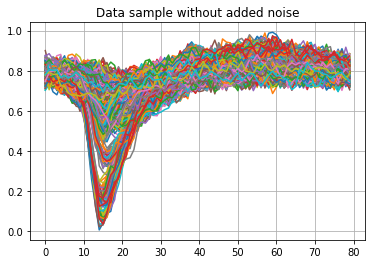

In [ ]:
plt.grid()
for i in range(1000):
  plt.plot(np.arange(80), train_data[i])
plt.title("Data sample without added noise")
plt.show()

Adding noise to real spikes data:


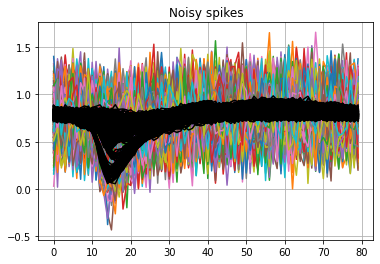

In [ ]:
noise = 0.2
noisy_train_data = train_data + noise * tf.random.normal(shape=train_data.shape)
noisy_test_data = test_data + noise * tf.random.normal(shape=test_data.shape)
noisy_validation_data = validation_data + noise * tf.random.normal(shape=validation_data.shape)
plt.grid()
for i in range(700):
  plt.plot(np.arange(80), noisy_test_data[i])
  plt.plot(np.arange(80), test_data[i], c='black')
for i in range(700):
  plt.plot(np.arange(80), test_data[i], c='black')
plt.title("Noisy spikes")
plt.show()

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Reshape((80, 1), input_shape=(80,)),
      layers.Conv1D(64, 5, activation='relu', padding='same', strides=2),
      layers.Conv1D(32, 5, activation='relu', padding='same', strides=2),
      layers.Conv1D(32, 5, activation='relu', padding='same', strides=2),
      layers.Dropout(0.2),
      # layers.Conv1D(32, 5, activation='relu', padding='same', strides=2),
      # layers.Conv1D(32, 5, activation='relu', padding='same', strides=2),
      layers.Conv1D(1, 5, activation='relu', padding='same', strides=1)])

    self.decoder = tf.keras.Sequential([
      layers.Conv1DTranspose(1, kernel_size=3, strides=2, activation='relu', padding='same'),                                 
      layers.Conv1DTranspose(64, kernel_size=5, strides=2, activation='relu', padding='same'),
      layers.Dropout(0.2),
      layers.Conv1DTranspose(32, kernel_size=5, strides=2, activation='relu', padding='same'),
      # layers.Conv1DTranspose(32, kernel_size=5, strides=2, activation='relu', padding='same'),
      # layers.Conv1DTranspose(32, kernel_size=5, strides=2, activation='relu', padding='same'),
      # layers.Conv1DTranspose(64, kernel_size=5, strides=1, activation='relu', padding='same'),
      layers.Conv1D(1, kernel_size=5, activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(noisy_train_data, train_data,
                epochs=10,
                shuffle=True,
                validation_data=(noisy_validation_data, validation_data))

Epoch 1/10
544/544 [==============================] - 5s 8ms/step - loss: 0.0073 - val_loss: 0.0044
Epoch 2/10
544/544 [==============================] - 4s 7ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 3/10
544/544 [==============================] - 4s 7ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 4/10
544/544 [==============================] - 4s 7ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/10
544/544 [==============================] - 4s 7ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/10
544/544 [==============================] - 4s 7ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/10
544/544 [==============================] - 4s 7ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/10
544/544 [==============================] - 4s 7ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/10
544/544 [==============================] - 4s 7ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/10
544/544 [==============================] - 4s 8ms/step - loss: 0.0014 - val_loss: 0.0013

In [ ]:
autoencoder.encoder.summary()
print()
autoencoder.decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 1)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 40, 64)            384       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 20, 32)            10272     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 32)            5152      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 10, 1)             161       
Total params: 15,969
Trainable params: 15,969
Non-trainable params: 0
__________________________________________________

In [ ]:
encoded_signal = autoencoder.encoder(test_data).numpy()
decoded_signal = autoencoder.decoder(encoded_signal).numpy()


In [ ]:
l = []
for i in range(8286):
  l.append(test_data[i])

a = np.asarray(l)
b = a.reshape(8286,-1)
b.shape
np.savetxt("noisy_data2.csv", b, delimiter=",")
!cp "/content/noisy_data2.csv" -r "/content/drive/MyDrive"

In [ ]:
l = []
for i in range(8286):
  l.append(decoded_signal[i])

a = np.asarray(l)
b = a.reshape(8286,-1)
b.shape
np.savetxt("denoised_data2.csv", b, delimiter=",")
!cp "/content/denoised_data2.csv" -r "/content/drive/MyDrive"


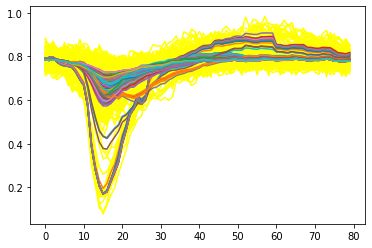

In [ ]:
for i in range(200):
  # plt.plot(np.arange(80), noisy_test_data[i], label='noisy data')
  plt.plot(np.arange(80), test_data[i], color='yellow', label='original data')
  # plt.plot(np.arange(80), decoded_signal[i], label='reconstructed data')
for i in range(200):
  # plt.plot(np.arange(80), test_data[i], label='noisy data')
  #plt.plot(np.arange(80), test_data[i], color='black', label='original data')
  plt.plot(np.arange(80), b[i], label='reconstructed data')
plt.show()

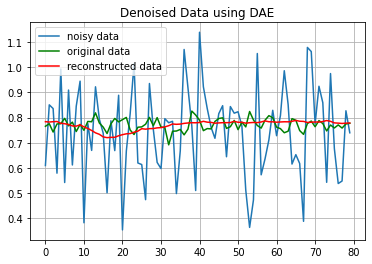

In [ ]:
plt.grid()
plt.plot(np.arange(80), noisy_test_data[26], label='noisy data')
plt.plot(np.arange(80), test_data[26], color='green', label='original data')
plt.plot(np.arange(80), decoded_signal[26], color='red', label='reconstructed data')
plt.legend()
plt.title("Denoised Data using DAE")
plt.show()

In [ ]:
# min = tf.reduce_min(chanel_1)
# max = tf.reduce_max(chanel_1)

chanel_1 = (chanel_1 - min_val) / (max_val - min_val)
encoded_signal = autoencoder.encoder(chanel_1).numpy()
decoded_signal = autoencoder.decoder(encoded_signal).numpy()

In [ ]:
for i in range(10):
  # plt.plot(np.arange(80), noisy_test_data[i], label='noisy data')
  plt.plot(np.arange(80), chanel_1[i], color='yellow', label='original data')
  # plt.plot(np.arange(80), decoded_signal[i], label='reconstructed data')
for i in range(10):
  # plt.plot(np.arange(80), test_data[i], label='noisy data')
  #plt.plot(np.arange(80), test_data[i], color='black', label='original data')
  plt.plot(np.arange(80), decoded_signal[i], label='reconstructed data')
plt.show()